In [3]:
import os
from os.path import dirname, realpath
import sys
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
if __name__ == '__main__':
    # Replace with standardized filenames when pipeline for previous task is ready
    filenames = ['DrugVisData.csv']

    data_dir = '../data/'
    out_dir = '../data/output/'

    # negated term list (use the human annotated version)
    neg_list = pd.read_csv(data_dir + 'neg_list_complete.txt', sep='\t', header=0)
    neg = neg_list['ITEM'].values
    neg_term = [' ' + item + ' ' for item in neg]
    neg_term.extend(item + ' ' for item in neg)

    for filename in filenames:
        data = pd.read_csv(data_dir+filename, index_col=False)

        output_data = data

        print(datetime.datetime.now())

        for i in range(0,len(data)):
            if pd.isnull(data.loc[i,'sentence']):
                output_data.loc[i,'Is_Negated'] = 0
            else:
                if any(substring in ' ' + data.loc[i,'sentence'].lower() for substring in neg_term):
                    output_data.loc[i,'Is_Negated'] = 1
                else:
                    output_data.loc[i,'Is_Negated'] = 0
                                        
        print(datetime.datetime.now())
        
        # remove file extension from file name and save results in an output file
        output_data.to_csv(out_dir + filename[:-4] + '_Negated_Output.csv',index=False)

2020-04-08 13:51:42.656092
2020-04-08 13:54:04.886987


In [7]:
negated_drug_mentions = output_data.loc[output_data.Is_Negated==1,'drug']\
                                    .groupby(output_data['drug'])\
                                    .value_counts()\
                                    .droplevel(level=0)
print('Top 20 most negated drugs:\n')
print(negated_drug_mentions.nlargest(20))

Top 20 most negated drugs:

drug
ribavirin             244
oseltamivir            89
amoxicillin            71
doxycycline            56
dexamethasone          51
prednisolone           47
methylprednisolone     46
prednisone             45
azithromycin           41
aspirin                39
acyclovir              37
amantadine             34
metronidazole          33
trypsin                33
ampicillin             31
chloroquine            31
vancomycin             31
ceftriaxone            30
cyclophosphamide       30
zanamivir              25
Name: drug, dtype: int64


In [8]:
asserted_drug_mentions = output_data.loc[output_data.Is_Negated==0,'drug']\
                                    .groupby(output_data['drug'])\
                                    .value_counts()\
                                    .droplevel(level=0)
print('Top 20 most asserted drugs:\n')
print(asserted_drug_mentions.nlargest(20))

Top 20 most asserted drugs:

drug
ribavirin             973
oseltamivir           522
amoxicillin           312
methylprednisolone    269
prednisolone          267
metronidazole         262
doxycycline           252
dexamethasone         244
prednisone            244
acyclovir             225
azithromycin          215
zanamivir             203
trypsin               190
vancomycin            182
tetracycline          178
ganciclovir           175
ampicillin            174
ceftriaxone           171
clindamycin           165
cyclophosphamide      162
Name: drug, dtype: int64


In [78]:
drug_mentions = output_data.groupby([output_data['drug'],output_data.Is_Negated])\
                            .size().to_frame(name = 'size').reset_index()\
                            .pivot(index='drug',columns='Is_Negated',values='size').fillna(0).reset_index()

drug_mentions['Percentage Negations'] = (drug_mentions[1]*100)/(drug_mentions[0]+drug_mentions[1])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024426EF4F08>]],
      dtype=object)

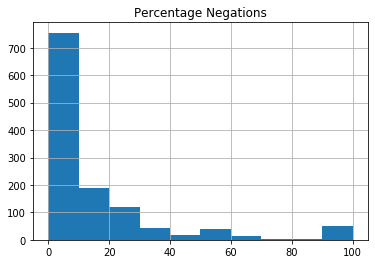

In [98]:
# distribution of percentage negated mentions of drugs
drug_mentions.hist(column='Percentage Negations')

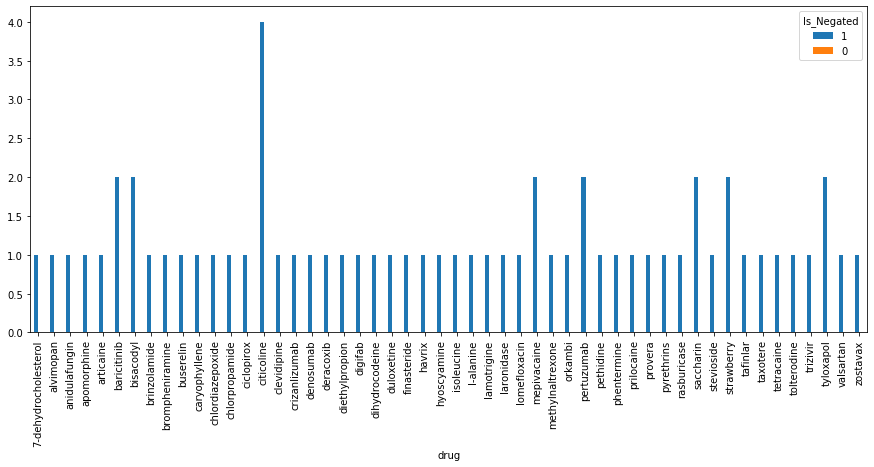

In [93]:
# drugs with 100% negation
drug_mentions.nlargest(n=1,columns='Percentage Negations',keep='all').plot.bar('drug',[1,0],figsize=(15,6))

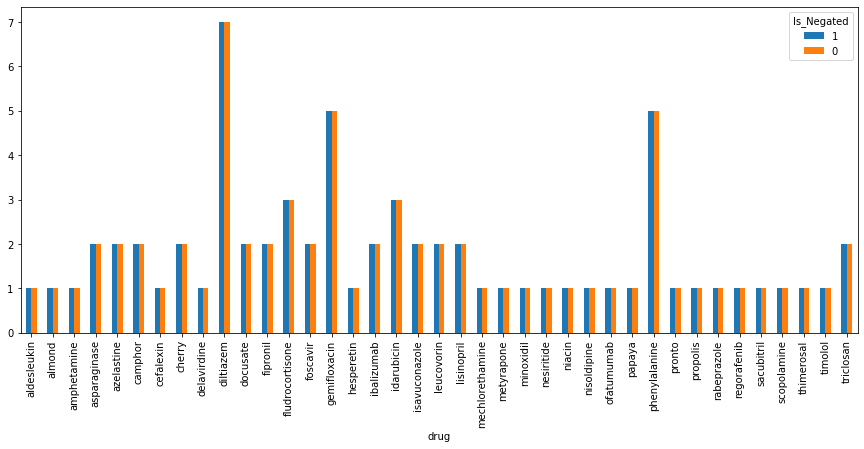

In [100]:
# drugs with 50% negation
drug_mentions.loc[drug_mentions['Percentage Negations']==50,:].plot.bar('drug',[1,0],figsize=(15,6))

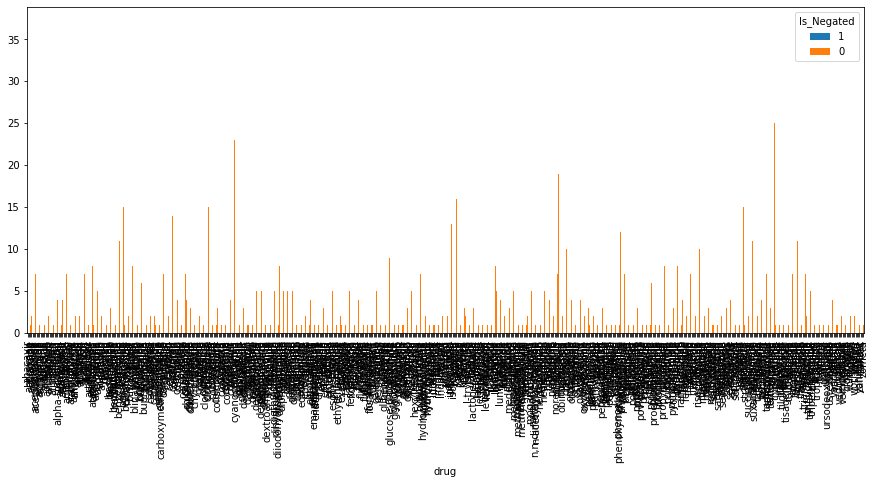

In [92]:
# drugs with 0 % negation
drug_mentions.nsmallest(n=1,columns='Percentage Negations',keep='all').plot.bar('drug',[1,0],figsize=(15,6))

#### Pros:
- quick and easy
- curated list of trigger terms for the medical context which includes words like "ineffective", that are not recognized 
  as negation by standard dependancy parsing libraries such as scispacy

#### Cons:
- does not capture cases such as 
    (a) sentences with buts
    (b) comparison of drugs
    (c) when there is a negation word which is unrelated to the drug Eg. "The drug is recommended in cases where the patient is not suffering from a prior chronical disease"
    (d) when negation is understood only with prior medical knowledge
    (e) double negation Eg. "not ineffective" or "not useless"